<a href="https://colab.research.google.com/github/sdittmeier/pytorch_course/blob/main/pytorch_trackml_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# install trackml dependency from repository
!pip install git+https://github.com/LAL/trackml-library

  Cloning https://github.com/LAL/trackml-library to /tmp/pip-req-build-31w1yowj
  Running command git clone --filter=blob:none --quiet https://github.com/LAL/trackml-library /tmp/pip-req-build-31w1yowj
  Resolved https://github.com/LAL/trackml-library to commit 53a165e15a2c885f54c2bef1bd1ed53db6ed9648
  Preparing metadata (setup.py) ... done
  Created wheel for trackml: filename=trackml-3-py2.py3-none-any.whl size=13502 sha256=d6d23b1c2746f3d1d3d743f961d9580b6cb7edfeb7907133f7ac1ea50aaec827
  Stored in directory: /tmp/pip-ephem-wheel-cache-bl8727be/wheels/c4/c4/7a/3289821a1c62668e88d3bcb858c68fee48c27009da0bd9b38d
Successfully built trackml


In [3]:
# download of zipped datasets
!mkdir datasets
!wget https://www.physi.uni-heidelberg.de/~dittmeier/pytorch/trackml_data/testset.zip
!wget https://www.physi.uni-heidelberg.de/~dittmeier/pytorch/trackml_data/valset.zip
!wget https://www.physi.uni-heidelberg.de/~dittmeier/pytorch/trackml_data/trainset.zip

--2024-03-22 10:10:48--  https://www.physi.uni-heidelberg.de/~dittmeier/pytorch/trackml_data/testset.zip
Resolving www.physi.uni-heidelberg.de (www.physi.uni-heidelberg.de)... 147.142.19.243
Connecting to www.physi.uni-heidelberg.de (www.physi.uni-heidelberg.de)|147.142.19.243|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 77311449 (74M) [application/zip]
Saving to: ‘testset.zip’

testset.zip         100%[===================>]  73.73M  21.0MB/s    in 3.5s    

2024-03-22 10:10:53 (21.0 MB/s) - ‘testset.zip’ saved [77311449/77311449]

--2024-03-22 10:10:53--  https://www.physi.uni-heidelberg.de/~dittmeier/pytorch/trackml_data/valset.zip
Resolving www.physi.uni-heidelberg.de (www.physi.uni-heidelberg.de)... 147.142.19.243
Connecting to www.physi.uni-heidelberg.de (www.physi.uni-heidelberg.de)|147.142.19.243|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 81081570 (77M) [application/zip]
Saving to: ‘valset.zip’

valset.zip          100%

In [4]:
# and unzip them into our datasets directory
!unzip trainset.zip -d datasets
!unzip valset.zip -d datasets
!unzip testset.zip -d datasets

Archive:  trainset.zip
   creating: datasets/trainset/
  inflating: datasets/trainset/event000021077-particles.csv  
  inflating: datasets/trainset/event000021075-particles.csv  
  inflating: datasets/trainset/event000021078-particles.csv  
  inflating: datasets/trainset/event000021067-particles.csv  
  inflating: datasets/trainset/event000021043-hits.csv  
  inflating: datasets/trainset/event000021058-particles.csv  
  inflating: datasets/trainset/event000021004-truth.csv  
  inflating: datasets/trainset/event000021020-hits.csv  
  inflating: datasets/trainset/event000021044-truth.csv  
  inflating: datasets/trainset/event000021041-cells.csv  
  inflating: datasets/trainset/event000021061-cells.csv  
  inflating: datasets/trainset/event000021077-cells.csv  
  inflating: datasets/trainset/event000021014-cells.csv  
  inflating: datasets/trainset/event000021020-cells.csv  
  inflating: datasets/trainset/event000021048-particles.csv  
  inflating: datasets/trainset/event000021038-truth.c

In [5]:
# Imports
import torch
from torch import nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import trackml.dataset
from trackml.utils import add_momentum_quantities
import matplotlib.pyplot as plt
import numpy as np


In [6]:
# helper for GPU training
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

cpu


   hit_id         particle_id         tx        ty      tz       tpx  \
0       1  238697583478833152 -86.806602 -14.74600 -1502.5 -0.247412   
1       2  671044522095935488 -68.705399 -10.91280 -1502.5 -0.526919   
2       3  774632811083595776 -56.143101  -9.52382 -1502.5 -1.053290   
3       4  945760182355361792 -60.311501  -4.98039 -1502.5 -1.179080   
4       5  837680800685096960 -89.389702  -8.82342 -1502.5 -1.395490   

        tpy        tpz    weight  
0 -0.068921  -4.570100  0.000006  
1 -0.108128 -11.914000  0.000007  
2 -0.156064 -28.250999  0.000017  
3 -0.120229 -30.253500  0.000016  
4 -0.106162 -23.752899  0.000018  
0                     17851
968276737383202816       20
932250276826447872       19
454865967546105856       18
45038951211204608        18
                      ...  
67556124731117569         1
481891551056764930        1
247711104942219266        1
666536386983100416        1
945772208280571905        1
Name: particle_id, Length: 10892, dtype: int64


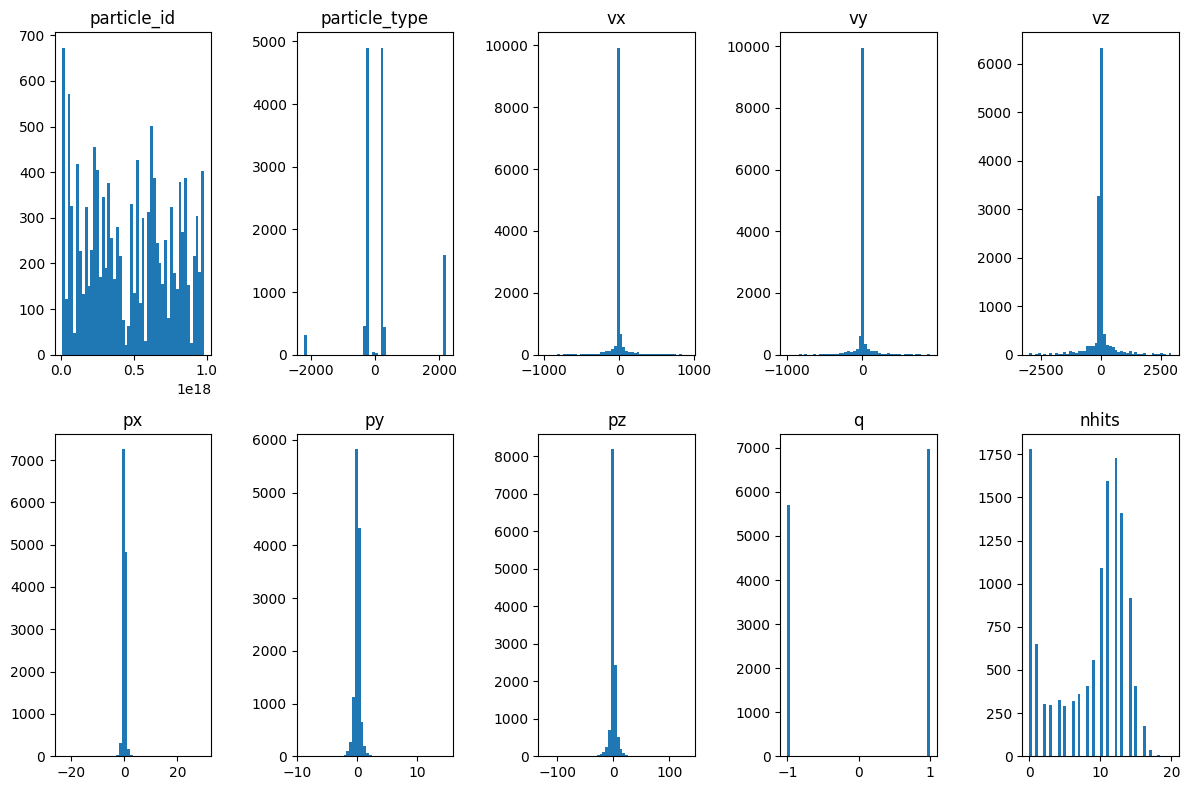

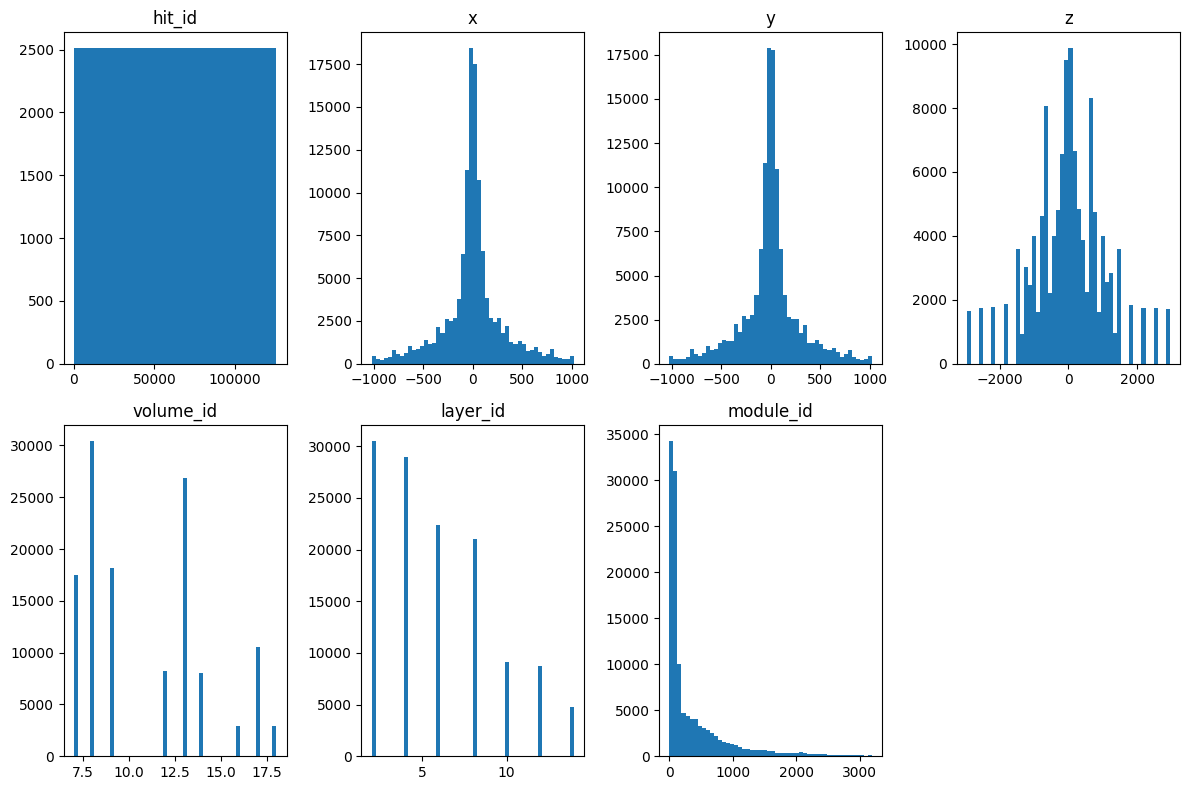

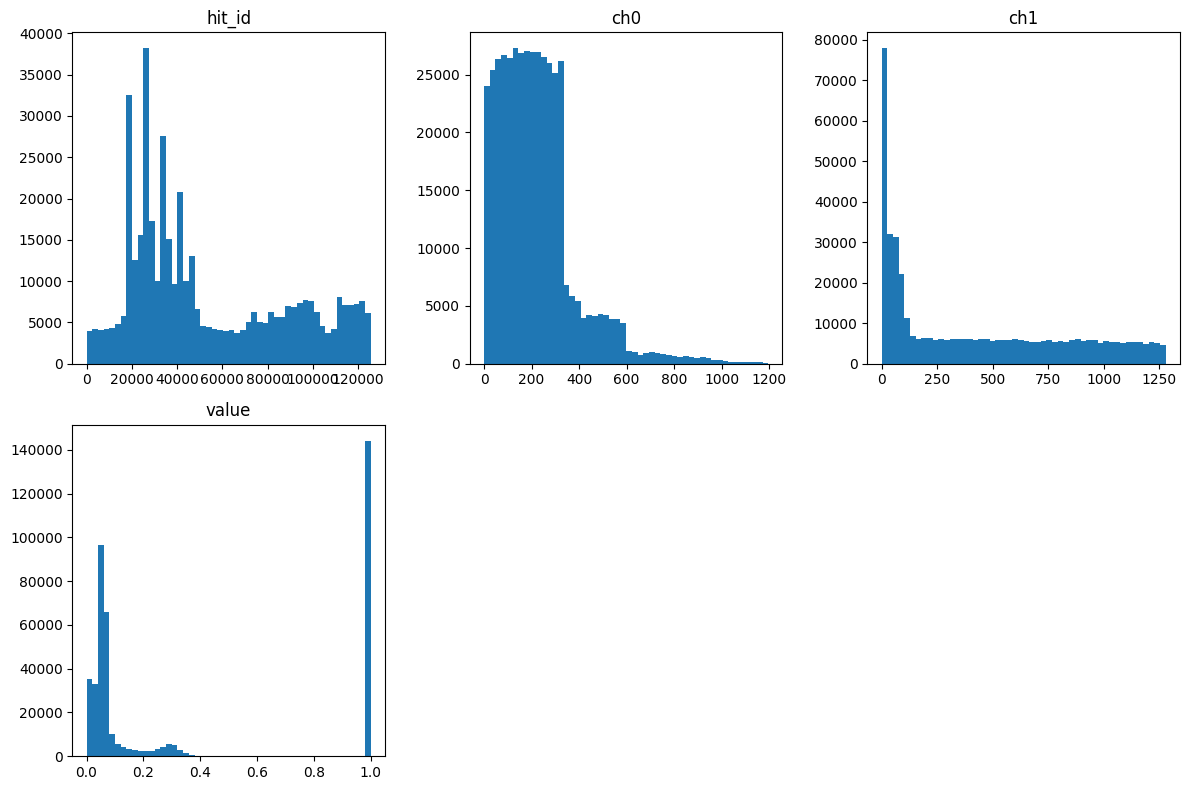

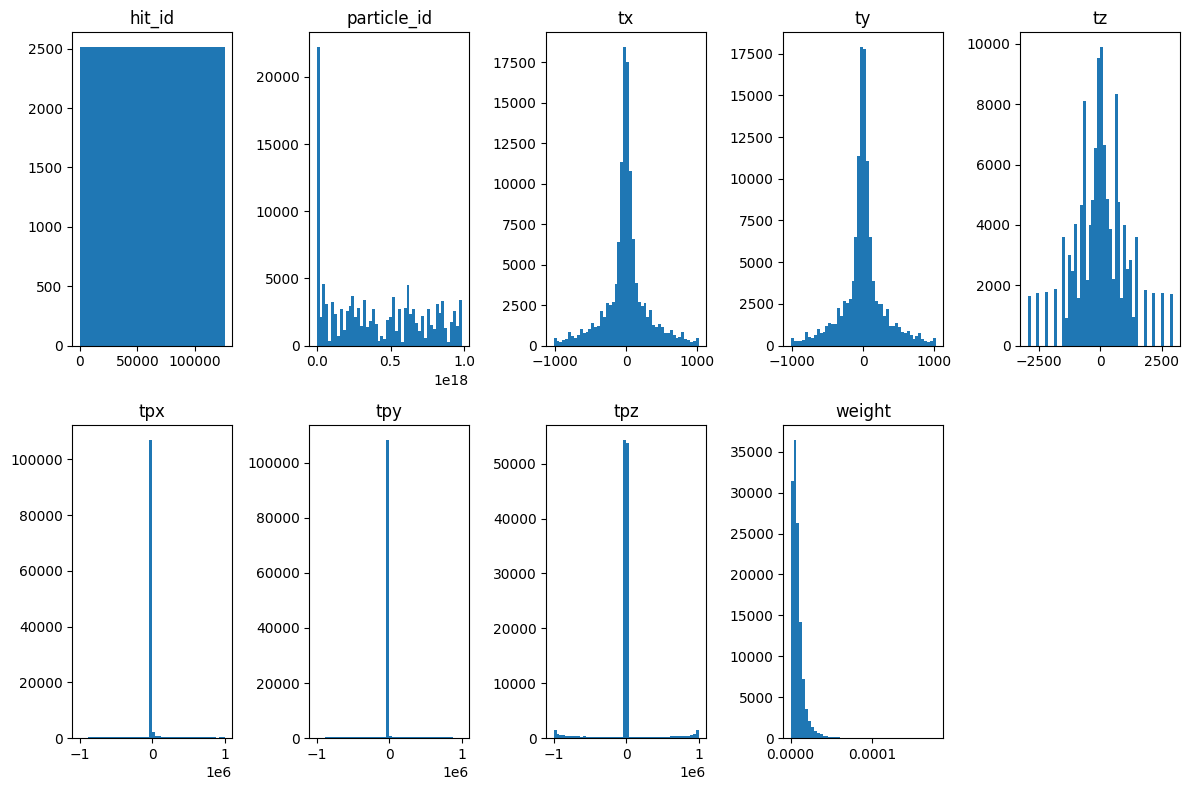

In [7]:
# Data Visualization
event_path = "datasets/trainset/event000021000"

particles, hits, cells, truth = trackml.dataset.load_event(
    event_path, parts=["particles", "hits", "cells", "truth"]
)

print(truth.head())
print(truth["particle_id"].value_counts())

# Create histograms for particles
plt.figure(figsize=(12, 8))
for i, column in enumerate(particles.columns):
    plt.subplot(2, 5, i+1)
    plt.hist(particles[column], bins=50)
    plt.title(column)
plt.tight_layout()
plt.show()

# Create histograms for hits
plt.figure(figsize=(12, 8))
for i, column in enumerate(hits.columns):
    plt.subplot(2, 4, i+1)
    plt.hist(hits[column], bins=50)
    plt.title(column)
plt.tight_layout()
plt.show()

# Create histograms for cells
plt.figure(figsize=(12, 8))
for i, column in enumerate(cells.columns):
    plt.subplot(2, 3, i+1)
    plt.hist(cells[column], bins=50)
    plt.title(column)
plt.tight_layout()
plt.show()

# Create histograms for truth
plt.figure(figsize=(12, 8))
for i, column in enumerate(truth.columns):
    plt.subplot(2, 5, i+1)
    plt.hist(truth[column], bins=50)
    plt.title(column)
plt.tight_layout()
plt.show()


In [8]:
# more visualisation, setup for a 3D plot
!pip install ipympl
from mpl_toolkits.mplot3d import Axes3D
from google.colab import output
output.enable_custom_widget_manager()
%matplotlib widget

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 511.6/511.6 kB 7.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 14.5 MB/s eta 0:00:00


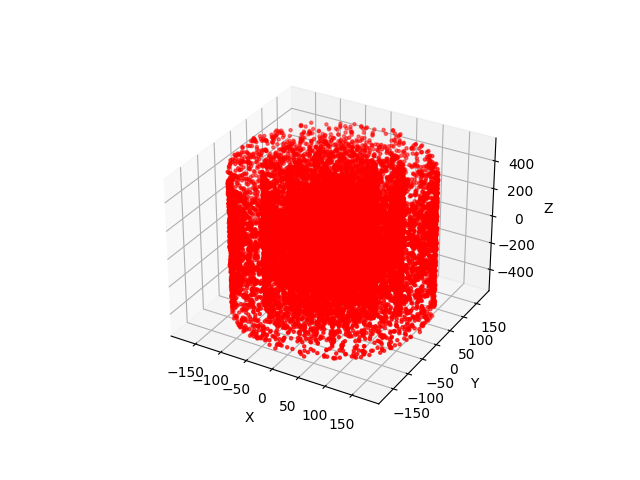

In [9]:
# Creating a 3D scatter plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
hits_select = hits[hits.volume_id==8]
ax.scatter(hits_select.x, hits_select.y, hits_select.z, c='r', marker='.')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.show()


In [26]:
# Create a dataset, with a label for each hit, if hits have same particle_id set to 1, else -1
# and an option to apply a cut on pT on the dataset

class TrackMLDataset(Dataset):
    def __init__(self, event_path, nevents=10, cuts=None):
        self.event_path = event_path
        self.nevents = nevents
        self.event_ids = []
        self.particles = []
        self.hits = []
        self.cells = []
        self.truth = []
        self.labels = []

        for event_id, hits, cells, particles, truth in trackml.dataset.load_dataset(event_path, nevents=nevents):
            particles = add_momentum_quantities(particles)
            print(event_id)
            if cuts is not None:
                print(f"Applying cuts: {cuts}")
                particles = particles[particles.pt >= cuts["pt"]].reset_index(drop=True)
                truth = truth[truth.particle_id.isin(particles.particle_id)].reset_index(drop=True)
                hits  = hits[hits.hit_id.isin(truth.hit_id)].reset_index(drop=True)
                cells = cells[cells.hit_id.isin(hits.hit_id)].reset_index(drop=True)

            self.event_ids.append(event_id)
            self.particles.append(particles)
            self.hits.append(hits)
            self.cells.append(cells)
            self.truth.append(truth)

            labels = np.full((len(truth), len(truth)), -1, dtype=np.int8)    # this is not memory friendly!!!
            for particle_id, nhits in zip(particles.particle_id, particles.nhits):
                particle_hits = truth[truth.particle_id == particle_id].index
                for match in particle_hits:
                    for match2 in particle_hits:
                        labels[match, match2] = 1

            # think about metric learning approach; make use of volumes and layers

            self.labels.append(labels)

    def __len__(self):
        return len(self.event_ids)

    def __getitem__(self, idx):
        event_id = self.event_ids[idx]
        particles = self.particles[idx]
        hits = self.hits[idx]
        cells = self.cells[idx]
        truth = self.truth[idx]
        labels = self.labels[idx]
        return event_id, torch.tensor(particles.values, dtype=torch.float32), torch.tensor(hits.values, dtype=torch.float32), torch.tensor(cells.values, dtype=torch.float32), torch.tensor(truth.values, dtype=torch.float32), torch.from_numpy(labels).type(torch.int8)


In [11]:
# Loading the dataset
print("Loading Trainset")
event_path = "datasets/trainset"
training_data = TrackMLDataset(event_path, nevents=80, cuts={"pt": 2})
print("Loading Valset")
event_path = "datasets/valset"
val_data = TrackMLDataset(event_path, nevents=10, cuts={"pt": 2})
print("Loading Testset")
event_path = "datasets/testset"
test_data = TrackMLDataset(event_path, nevents=10, cuts={"pt": 2})

Loading Trainset
21000
Applying cuts: {'pt': 2}
21001
Applying cuts: {'pt': 2}
21002
Applying cuts: {'pt': 2}
21003
Applying cuts: {'pt': 2}
21004
Applying cuts: {'pt': 2}
21005
Applying cuts: {'pt': 2}
21006
Applying cuts: {'pt': 2}
21007
Applying cuts: {'pt': 2}
21008
Applying cuts: {'pt': 2}
21009
Applying cuts: {'pt': 2}
21010
Applying cuts: {'pt': 2}
21011
Applying cuts: {'pt': 2}
21012
Applying cuts: {'pt': 2}
21013
Applying cuts: {'pt': 2}
21014
Applying cuts: {'pt': 2}
21015
Applying cuts: {'pt': 2}
21016
Applying cuts: {'pt': 2}
21017
Applying cuts: {'pt': 2}
21018
Applying cuts: {'pt': 2}
21019
Applying cuts: {'pt': 2}
21020
Applying cuts: {'pt': 2}
21021
Applying cuts: {'pt': 2}
21022
Applying cuts: {'pt': 2}
21023
Applying cuts: {'pt': 2}
21024
Applying cuts: {'pt': 2}
21025
Applying cuts: {'pt': 2}
21026
Applying cuts: {'pt': 2}
21027
Applying cuts: {'pt': 2}
21028
Applying cuts: {'pt': 2}
21029
Applying cuts: {'pt': 2}
21030
Applying cuts: {'pt': 2}
21031
Applying cuts: {

In [27]:
# Setting up DataLoader
batch_size = 1
train_dataloader = DataLoader(training_data, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_data, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=True)

# Getting a first test event
event_id, particles, hits, cells, truth, labels = next(iter(train_dataloader))

print(f"event_id shape: {event_id.size()}; event_id data type: {event_id.dtype}")
print(f"particles shape: {particles.size()}; particles data type: {particles.dtype}")
print(f"hits shape: {hits.size()}; hits data type: {hits.dtype}")
print(f"cells shape: {cells.size()}; cells data type: {cells.dtype}")
print(f"truth shape: {truth.size()}; truth data type: {truth.dtype}")
print(f"labels shape: {labels.size()}; labels data type: {labels.dtype}")

print(f"event_id: {event_id.squeeze()}")
print(f"hit coordinates: {hits.squeeze()[:,1:4]}")    # x, y, z
print(f"labels: {labels.squeeze()}")



event_id shape: torch.Size([1]); event_id data type: torch.int64
particles shape: torch.Size([1, 138, 14]); particles data type: torch.float32
hits shape: torch.Size([1, 1522, 7]); hits data type: torch.float32
cells shape: torch.Size([1, 4301, 4]); cells data type: torch.float32
truth shape: torch.Size([1, 1522, 9]); truth data type: torch.float32
labels shape: torch.Size([1, 1522, 1522]); labels data type: torch.int8
event_id: 21070
hit coordinates: tensor([[-3.5329e+01, -8.9408e+01, -1.4975e+03],
        [ 1.5165e+00, -1.6867e+02, -1.4980e+03],
        [ 1.4798e+01, -6.8170e+01, -1.4975e+03],
        ...,
        [ 9.6482e+02,  1.9144e+02,  2.9555e+03],
        [-6.8341e+02,  4.2077e+02,  2.9445e+03],
        [-8.1957e+02,  1.2393e+02,  2.9475e+03]])
labels: tensor([[ 1, -1, -1,  ..., -1, -1, -1],
        [-1,  1, -1,  ..., -1, -1, -1],
        [-1, -1,  1,  ..., -1, -1, -1],
        ...,
        [-1, -1, -1,  ...,  1, -1, -1],
        [-1, -1, -1,  ..., -1,  1, -1],
        [-1, -1

In [90]:
# Model definition
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear_relu_stack = nn.Sequential( # Sequential container
            nn.Linear(3, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, 8),
        )

    def forward(self, x):
        y = self.linear_relu_stack(x)
        return y

# instantiates the model and sends it to GPU
model = NeuralNetwork().to(device)

In [91]:
learning_rate = 1e-3
batch_size = batch_size
epochs = 10
margin = 1.0

loss_fn = nn.HingeEmbeddingLoss(margin=margin)

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [92]:
# loops over our optimization code
def train_loop(dataloader, model, loss_fn, optimizer, device):
    size = len(dataloader.dataset)
    # Set the model to training mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.train()

    for batch, [event_id, particles, hits, cells, truth, labels] in enumerate(dataloader):
        # Send data to GPU
        particles, hits, cells, truth, labels = to_device([particles, hits, cells, truth, labels], device)

        embedding = model(hits.squeeze()[:,1:4])
        distances = torch.cdist(embedding, embedding)

        loss = loss_fn(distances, labels)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 10 == 0:
            loss, current = loss.item(), batch * batch_size + len(event_id)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

        # Clear GPU memory
        del event_id, particles, hits, cells, truth, embedding, distances, labels, loss
        torch.cuda.empty_cache()



In [93]:
# we want to do a knn from scikit
from sklearn.neighbors import NearestNeighbors

def evaluate(embeddings, labels, knn, radius):
  embeddings_cpu = embeddings.cpu().detach().numpy()

  neigh = NearestNeighbors(n_neighbors=knn, radius=radius)
  neigh.fit(embeddings_cpu)
  distances, indices = neigh.kneighbors(embeddings_cpu)
  #print(distances)
  #print(indices)


  positives = 0
  negatives = 0

  count_1 = torch.sum(labels == 1).item()

  for ind, dist in zip(indices,distances):
    # we can just check with labels, if knn and label = 1 --> match, -1 --> bad
      valid_ind = ind[dist<radius]

      positives += torch.sum(labels.squeeze()[valid_ind[0],valid_ind[1:]] == 1).item()
      negatives += torch.sum(labels.squeeze()[valid_ind[0],valid_ind[1:]] == -1).item()
  print(f"positives: {positives}; negatives: {negatives}; count_1: {count_1}")
  efficiency = positives/count_1
  purity = positives/(positives + negatives)
  return efficiency, purity

In [94]:
# evaluate the model's performance against the test dataset
def test_loop(dataloader, model, loss_fn, device, knn, radius):
    # Set the model to evaluation mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, efficiency, purity = 0, 0, 0

    # Evaluating the model with torch.no_grad() ensures that no gradients are computed during test mode
    # also serves to reduce unnecessary gradient computations and memory usage for tensors with requires_grad=True
    with torch.no_grad():
        for event_id, particles, hits, cells, truth, labels  in dataloader:
            # Send data to GPU
            particles, hits, cells, truth, labels = to_device([particles, hits, cells, truth, labels], device)

            embedding = model(hits.squeeze()[:,1:4])
            distances = torch.cdist(embedding, embedding)

            test_loss += loss_fn(distances, labels).item()

            eff, pur = evaluate(embedding, labels, knn, radius)
            efficiency += eff
            purity += pur

            del event_id, particles, hits, cells, truth, embedding, distances, labels
            torch.cuda.empty_cache()

    test_loss /= num_batches
    efficiency /= num_batches
    purity /= num_batches
    print(f"Test Error: \n Avg loss: {test_loss:>8f} Efficiency: {efficiency:>8f} Purity: {purity:>8f} \n")
    return test_loss, efficiency, purity

In [97]:
loss = []
eff  = []
pur  = []
knn = 21
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_dataloader, model, loss_fn, optimizer, device)
    l,e,p = test_loop(val_dataloader, model, loss_fn, device, knn, margin)
    loss.append(l)
    eff.append(e)
    pur.append(p)
print("Done!")
new_res = [loss, eff, pur]


Epoch 1
-------------------------------
loss: 0.010635  [    1/   80]
loss: 0.010013  [   11/   80]
loss: 0.012712  [   21/   80]
loss: 0.009940  [   31/   80]
loss: 0.011380  [   41/   80]
loss: 0.010393  [   51/   80]
loss: 0.010650  [   61/   80]
loss: 0.011689  [   71/   80]
positives: 6876; negatives: 21816; count_1: 30723
positives: 9615; negatives: 32940; count_1: 44699
positives: 6390; negatives: 15192; count_1: 24708
positives: 8777; negatives: 29852; count_1: 39123
positives: 5364; negatives: 12865; count_1: 20340
positives: 7807; negatives: 24508; count_1: 35054
positives: 7485; negatives: 22082; count_1: 30367
positives: 9886; negatives: 30750; count_1: 42972
positives: 7635; negatives: 21098; count_1: 31708
positives: 7089; negatives: 22718; count_1: 31254
Test Error: 
 Avg loss: 0.012198 Efficiency: 0.235246 Purity: 0.252472 

Epoch 2
-------------------------------
loss: 0.011671  [    1/   80]
loss: 0.011209  [   11/   80]
loss: 0.008392  [   21/   80]
loss: 0.010626  [

[0.02405744269490242, 0.02224433459341526, 0.0191157472319901, 0.017439930234104395, 0.015050106495618821, 0.0157558168284595, 0.014469473343342542, 0.01296608354896307, 0.012183735240250826, 0.012026597838848829]


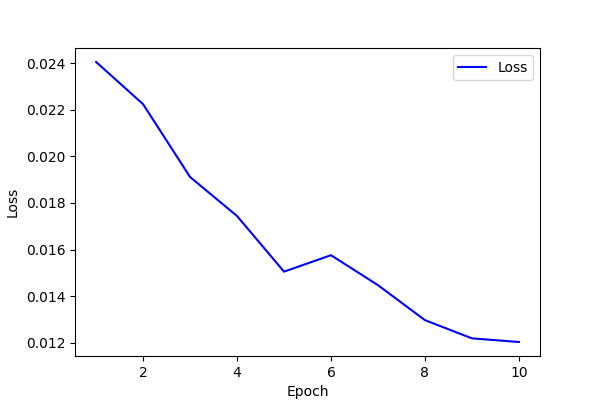

[0.10524983485598623, 0.11482372354967145, 0.1511779383785073, 0.15915728407525864, 0.20295792267904816, 0.18060501000130091, 0.1953064216193644, 0.22571220322780147, 0.24425964917795945, 0.23783858992388485]


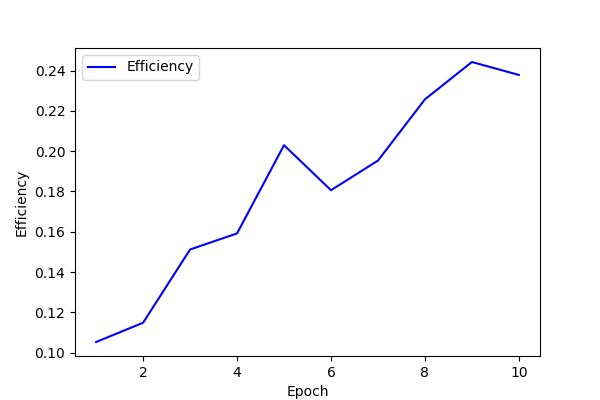

[0.16591028838702113, 0.16975642193086918, 0.19939587388627764, 0.20299347445129987, 0.2426365120497147, 0.22294490960400334, 0.23261282712634798, 0.2556161618322287, 0.25326311720229017, 0.25360261348793306]


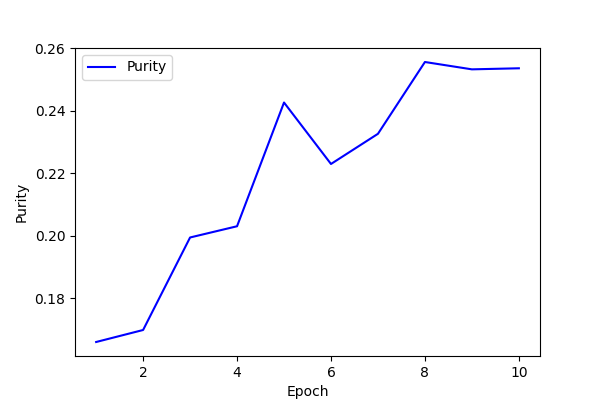

In [96]:
#for name, param in model.named_parameters():
#    print(f"Parameter name: {name}, Size: {param.size()}, Values: {param}")

# Assuming you have the `test_loss` variable containing the loss values for each epoch
epochs_r = range(1, len(loss) + 1)
for res, titles in zip (new_res, ["Loss", "Efficiency", "Purity"]):
    print(res)
    plt.figure(figsize=(6, 4))
    plt.plot(epochs_r, res, 'b', label=titles)
    plt.xlabel('Epoch')
    plt.ylabel(titles)
    plt.legend()
    plt.show()


In [99]:
test_loop(test_dataloader, model, loss_fn, device, 50, margin)
test_loop(test_dataloader, model, loss_fn, device, 100, margin)

positives: 8765; negatives: 43941; count_1: 34552
positives: 10317; negatives: 47224; count_1: 36387
positives: 5209; negatives: 19367; count_1: 21726
positives: 8554; negatives: 46084; count_1: 34583
positives: 8874; negatives: 37331; count_1: 34110
positives: 6677; negatives: 24856; count_1: 25119
positives: 9190; negatives: 43492; count_1: 34857
positives: 9674; negatives: 43531; count_1: 35180
positives: 13213; negatives: 84422; count_1: 50826
positives: 6544; negatives: 23434; count_1: 22943
Test Error: 
 Avg loss: 0.012552 Efficiency: 0.263412 Purity: 0.182781 

positives: 8719; negatives: 51372; count_1: 34583
positives: 8874; negatives: 48510; count_1: 34552
positives: 13688; negatives: 105656; count_1: 50826
positives: 9356; negatives: 49266; count_1: 34857
positives: 9744; negatives: 46360; count_1: 35180
positives: 5214; negatives: 19454; count_1: 21726
positives: 6714; negatives: 25590; count_1: 25119
positives: 10575; negatives: 55442; count_1: 36387
positives: 6616; negat

(0.012551982328295708, 0.26711288296709784, 0.17267283261300137)